In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = pd.read_csv('dynamic_pricing.csv')
data.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


## EXPLORATORY DATA ANALYSIS

In [3]:
data.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


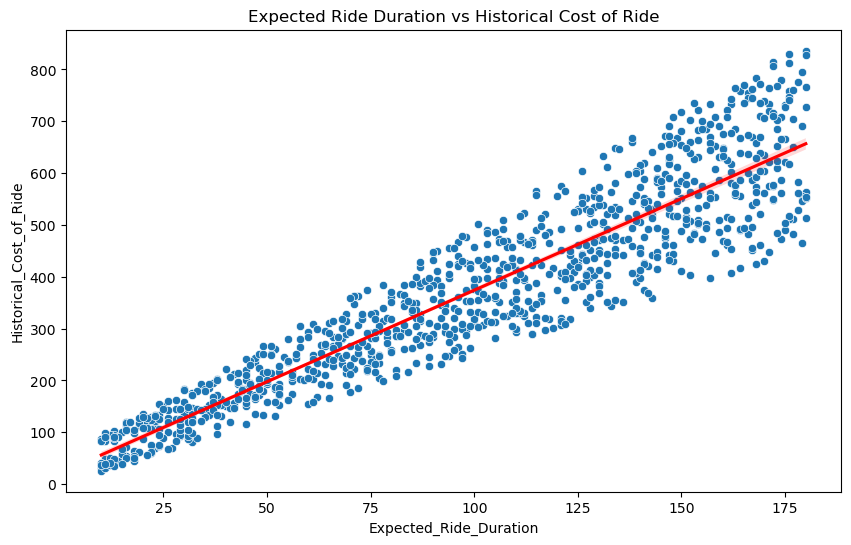

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Expected_Ride_Duration', y='Historical_Cost_of_Ride')
sns.regplot(data=data, x='Expected_Ride_Duration', y='Historical_Cost_of_Ride', scatter=False, color='red')
plt.title('Expected Ride Duration vs Historical Cost of Ride')
plt.show()

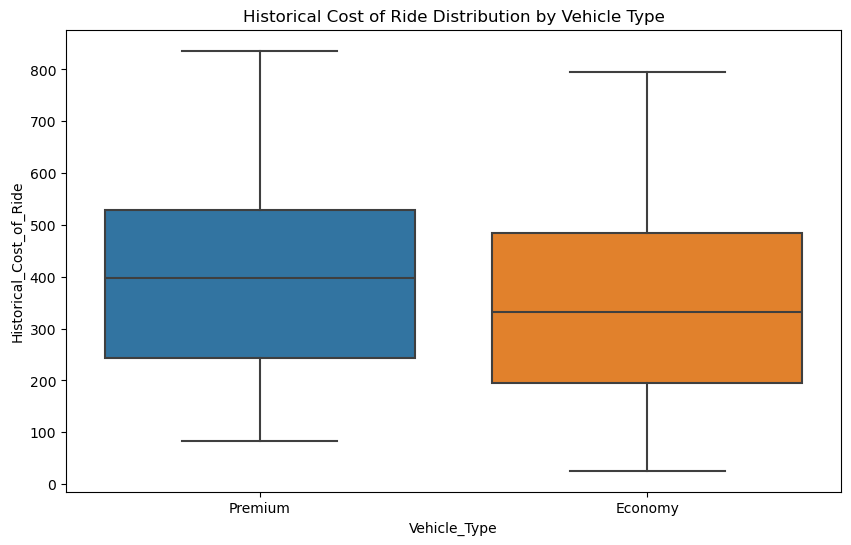

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Vehicle_Type', y='Historical_Cost_of_Ride')
plt.title('Historical Cost of Ride Distribution by Vehicle Type')
plt.show()


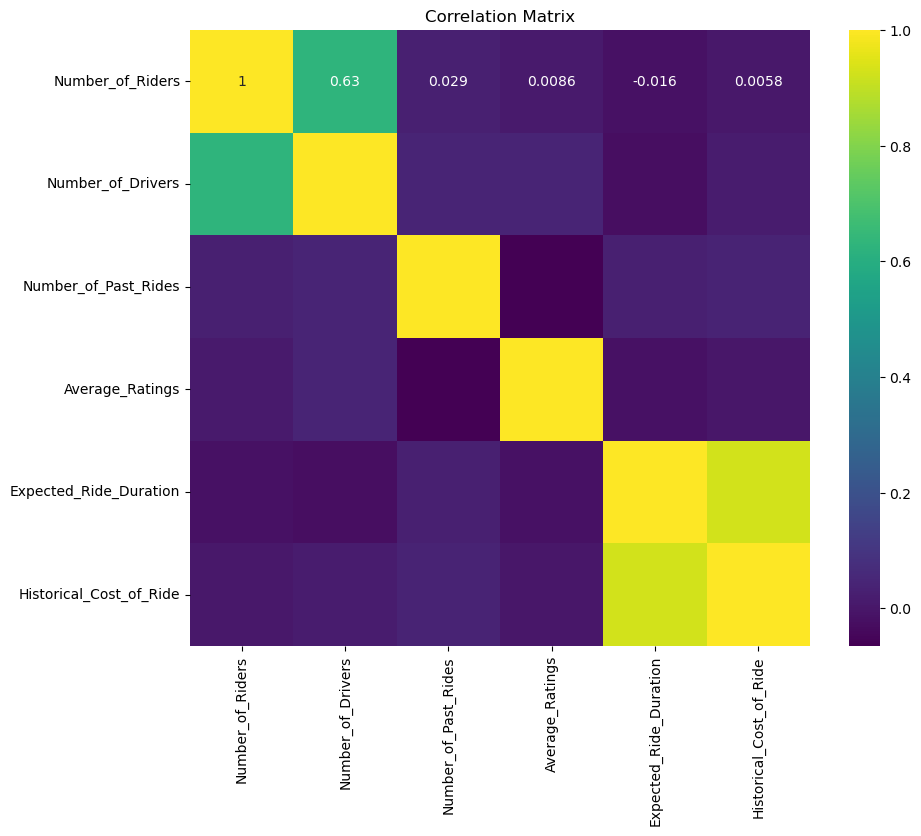

In [11]:
data1 = data.drop(columns=['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type'])
corr_matrix = data1.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()


## IMPLEMENTING DYNAMIC PRICING STRATEGY

In [19]:
high_demand_percentile = 75
low_demand_percentile = 25

data['demand_multiplier'] = np.where(data['Number_of_Riders'] > np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], low_demand_percentile))

high_supply_percentile = 75
low_supply_percentile = 25

data['supply_multiplier'] = np.where(data['Number_of_Drivers'] > np.percentile(data['Number_of_Drivers'], low_supply_percentile),
                                     np.percentile(data['Number_of_Drivers'], high_supply_percentile) / data['Number_of_Drivers'],
                                     np.percentile(data['Number_of_Drivers'], low_supply_percentile) / data['Number_of_Drivers'])

demand_threshold_high = 1.2
demand_threshold_low = 0.8
supply_threshold_high = 0.8
supply_threshold_low = 1.2

data['adjusted_ride_cost'] = data['Historical_Cost_of_Ride'] * (np.maximum(data['demand_multiplier'], demand_threshold_low) *
                                                               np.maximum(data['supply_multiplier'], supply_threshold_low))

data['profit_percentage'] = (data['adjusted_ride_cost'] - data['Historical_Cost_of_Ride']) / data['Historical_Cost_of_Ride']


## Profit percentage for each ride after this dynamic pricing strategy 

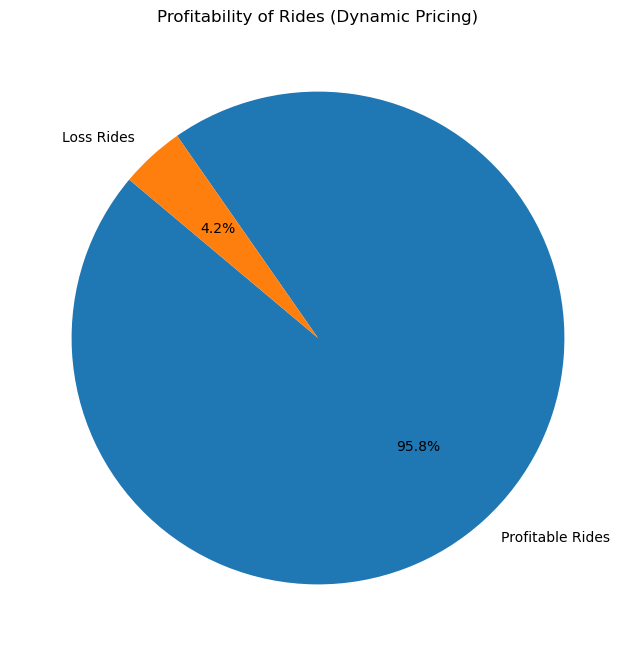

In [21]:
profitable_rides = data[data['profit_percentage'] > 0]
loss_rides = data[data['profit_percentage'] < 0]

profitable_ride_count = len(profitable_rides)
loss_ride_count = len(loss_rides)

labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_ride_count, loss_ride_count]

plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Profitability of Rides (Dynamic Pricing)')
plt.show()

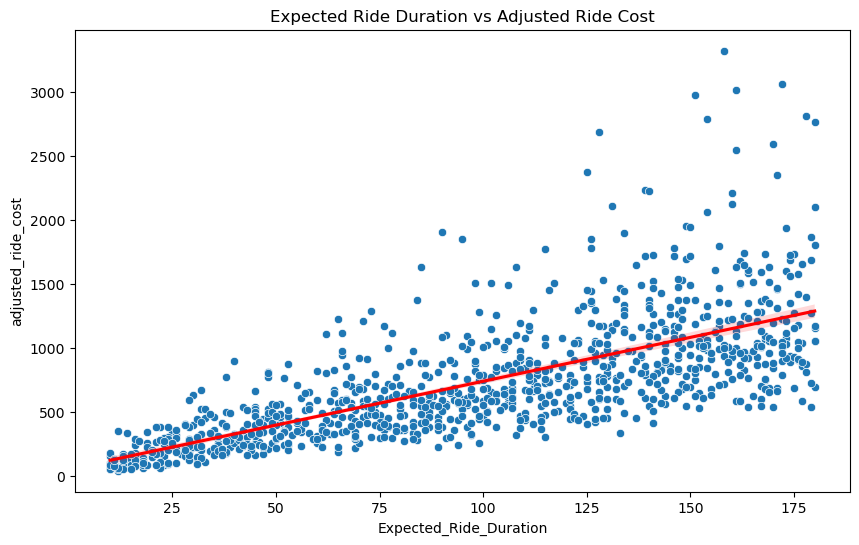

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Expected_Ride_Duration', y='adjusted_ride_cost')
sns.regplot(data=data, x='Expected_Ride_Duration', y='adjusted_ride_cost', scatter=False, color='red')
plt.title('Expected Ride Duration vs Adjusted Ride Cost')
plt.show()

## Training a Predictive Model

In [25]:
from sklearn.preprocessing import StandardScaler

In [33]:
def data_preprocessing_pipeline(data):
    numeric_features = data.select_dtypes(include=['float', 'int']).columns
    categorical_features = data.select_dtypes(include=['object']).columns

    data[numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())  # Handling Null Values

    for feature in numeric_features:
        q1 = data[feature].quantile(0.25)
        q3 = data[feature].quantile(0.75)
        IQR = q3 - q1
        lower_bound = q1 - 1.5 * IQR
        upper_bound = q3 + 1.5 * IQR

        data[feature] = np.where((data[feature] < lower_bound) | (data[feature] > upper_bound), data[feature].mean(), data[feature])

    data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])  # Handling Null Values

    return data

data['Vehicle_Type'] = data['Vehicle_Type'].map({'Premium': 1, 'Economy': 0})

## Splitting Data

In [35]:
from sklearn.model_selection import train_test_split
x = np.array(data[['Number_of_Riders', 'Number_of_Drivers', 'Vehicle_Type', 'Expected_Ride_Duration']])
y = np.array(data["adjusted_ride_cost"])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
y_train = y_train.ravel()  # Reshaping y to 1D array
y_test = y_test.ravel()

## Training Random Forest Regression Model

In [37]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

model.fit(x_train, y_train)

RandomForestRegressor()

In [39]:
def get_vehicle_type_numeric(vehicle_type):
    vehicle_type_mapping = {
        'Premium': 1,
        'Economy': 0
    }
    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    return vehicle_type_numeric

def predict_price(number_of_riders, number_of_drivers, vehicle_type, Expected_Ride_Duration):
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    if vehicle_type_numeric is None:
        raise ValueError('Invalid vehicle type')

    input_data = np.array([[number_of_riders, number_of_drivers, vehicle_type_numeric, Expected_Ride_Duration]])
    predicted_price = model.predict(input_data)
    return predicted_price

In [45]:
# Example :

user_number_of_riders = 80
user_number_of_drivers = 55
user_vehicle_type = "Economy"
Expected_Ride_Duration = 40
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, user_vehicle_type, Expected_Ride_Duration)
print("Predicted price:", predicted_price)

Predicted price: [335.61740552]
